# Recap

## Example: Pima Indians Diabetes Database
The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. All patients here are females at least 21 years old of Pima Indian heritage.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc, accuracy_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold 
from scipy import stats 

In [2]:
%matplotlib inline
sns.set(color_codes=True) # settings for seaborn plotting style
sns.set(rc={'figure.figsize':(5,5)}) # settings for seaborn plot sizes

## Data Analysis

In [3]:
df = pd.read_csv('.\data\diabetes.csv')
print(df.shape)
df.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


There are missing values for the features:
- Glucose
- BloodPressure
- SkinThickness 
- Insulin
- BMI

In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


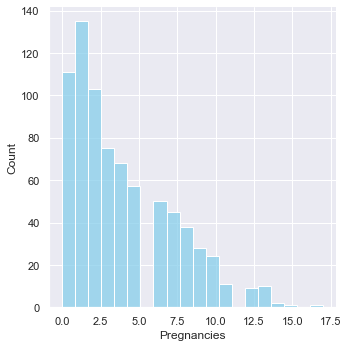

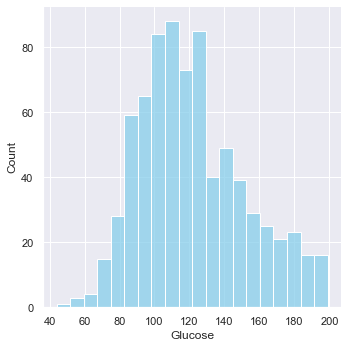

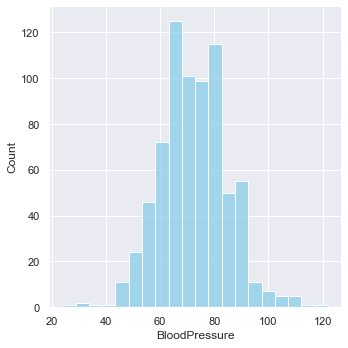

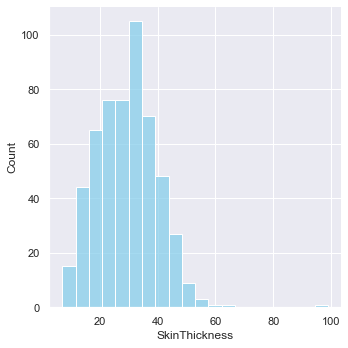

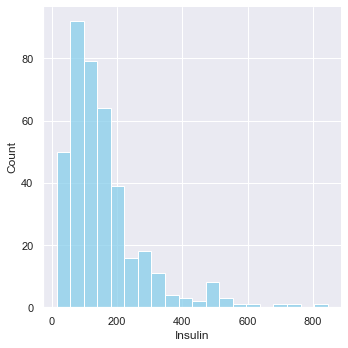

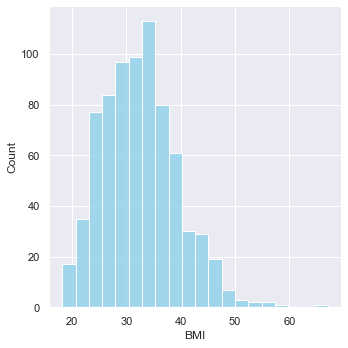

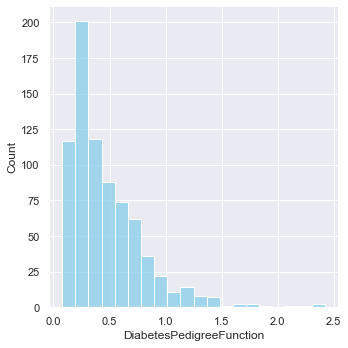

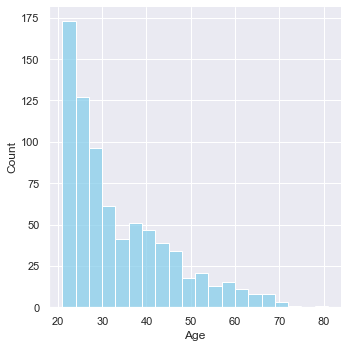

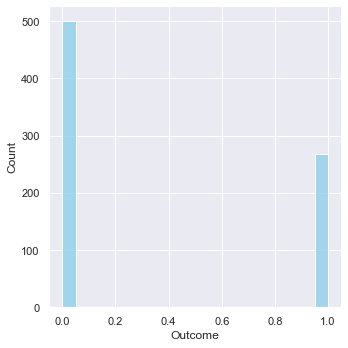

In [6]:
for col in df:
    sns.displot(df[col], bins=20, color='skyblue')

Interpretations from the above graphs.
- Age and Insulin columns are highly right skewed (can be calculated). 
- Dataset contains more number of people between the age of 20-40 years.
- Large number of people have blood pressure between 50 and 100 mmHg.
- Large number of people with insulin values of 0. Mostly insulin levels of 0 are seen in Type 1 diabetic patients.
- Lot of people have glucose levels between 100 and 200 mg/dL. People with Glucose levels between 140mg/dL and 199mg/dL are considered to be prediabetic.
- There are a lot of people in the BMI range of 20 and 50. A healthy adult should have a BMI between 18.5 and 24.9. This dataset obviously has many people who are either overweight or obese.

<AxesSubplot:>

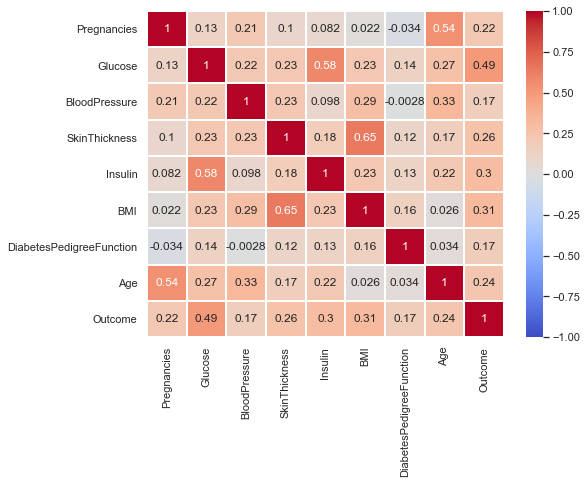

In [7]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot = True, vmin=-1, vmax=1, center= 0,
            cmap= 'coolwarm', linewidths=1,  cbar_kws= {'orientation': 'vertical'})

## Data Preprocessing

### Outliers 
We will check if we want to keep the outliers in pregnancies and SkinThickness.

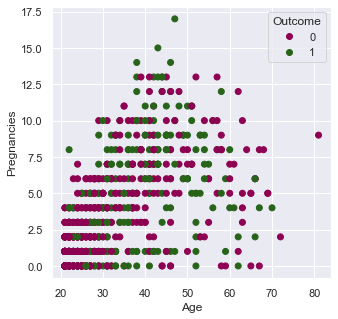

In [8]:
scatter = plt.scatter(df['Age'], df['Pregnancies'], c=df['Outcome'].astype('category').cat.codes ,cmap = 'PiYG' )
plt.xlabel('Age')
plt.ylabel('Pregnancies')
plt.legend(handles=scatter.legend_elements()[0], title="Outcome" , labels =[0,1])

In [9]:
df.loc[df[df['Pregnancies'] > 13].index, 'Pregnancies'] = 14

In [10]:
df[df['SkinThickness'] >= 60]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
57,0,100.0,88.0,60.0,110.0,46.8,0.962,31,0
445,0,180.0,78.0,63.0,14.0,59.4,2.420,25,1
579,2,197.0,70.0,99.0,NaN,34.7,0.575,62,1


In [11]:
df.loc[df[df['SkinThickness'] >= 60].index, 'SkinThickness'] = 60

### missing values
We saw different approaches to fill in the missing values.<br>
For simplicity I will use the same approach for all the feature and generate random values from normal distribution.

In [12]:
missing_cols = ['Glucose', 'BloodPressure','SkinThickness','Insulin', 'BMI']
for col in missing_cols:
    mu = df[col].mean()
    sigma = df[col].std()
    for row in df[df[col].isnull()].index:
        df.loc[row, col] = np.random.normal(mu, sigma)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


### Split to train and test

In [14]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Normalization
When there is a test data we should normalized it with the train data parameters.

In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Over sampeling
The data is imbalnced, we will use SMOTE to balance it.

In [16]:
y.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [17]:
X_train.shape

(576, 8)

In [18]:
smote = SMOTE(random_state=42)
X_train,y_train = smote.fit_resample(X_train, y_train.ravel())

In [19]:
X_train.shape

(754, 8)

## Classification

### Model evaluation

Confusion matrix: 

|  | predicted negative | predicted positive |
|:--- | :---: | :---: |
| actual negative | TN | FP|
| actual positive | FN | TP|

- sensitivity = recall =  $ \frac{TP}{TP+FN} $ 
- specificity = $ \frac{TN}{TN +FP} $
- precision = $ \frac{TP}{TP+FP}$ 
- f1-score = $ \frac{2*precision*recall}{precision+recall}$

#### What is the evaluation metric we should use in this problem?

In [20]:
rfc = RandomForestClassifier(n_estimators=200, random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(pd.DataFrame(confusion_matrix(y_test, y_pred)))
print(classification_report(y_test,y_pred))

    0   1
0  91  32
1  17  52
              precision    recall  f1-score   support

           0       0.84      0.74      0.79       123
           1       0.62      0.75      0.68        69

    accuracy                           0.74       192
   macro avg       0.73      0.75      0.73       192
weighted avg       0.76      0.74      0.75       192



### Hyperparameter Tuning

In [21]:
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num=4)] 
max_features = ['auto', 'sqrt']
max_depth = [2,4,6]
min_samples_leaf = [3,5]
bootstrap = [True, False]
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, scoring = 'recall', verbose=2, cv=5, n_jobs = -1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=200,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4, 6],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [3, 5],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='recall', verbose=2)

In [22]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 6,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'n_estimators': 150}

In [23]:
best_grid = grid_search.best_estimator_
grid_y_pred = best_grid.predict(X_test)
print(pd.DataFrame(confusion_matrix(y_test, grid_y_pred)))
print(classification_report(y_test,grid_y_pred))

    0   1
0  86  37
1  15  54
              precision    recall  f1-score   support

           0       0.85      0.70      0.77       123
           1       0.59      0.78      0.68        69

    accuracy                           0.73       192
   macro avg       0.72      0.74      0.72       192
weighted avg       0.76      0.73      0.73       192



### Models comparison

In [24]:
y_probs_rf = rfc.predict_proba(X_test)
fpr_rf, tpr_rf, t = roc_curve(y_test, y_probs_rf[:,1])
auc_rf = auc(fpr_rf, tpr_rf)

In [25]:
y_probs_grid = best_grid.predict_proba(X_test)
fpr_grid, tpr_grid, t = roc_curve(y_test, y_probs_grid[:,1])
auc_grid = auc(fpr_grid, tpr_grid)

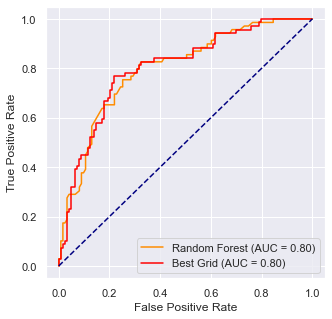

In [26]:
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', label='Random Forest (AUC = %0.2f)' %  auc_rf)
plt.plot(fpr_grid, tpr_grid, color='red', label='Best Grid (AUC = %0.2f)' %  auc_grid)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### t-test

In [27]:
clf_list = [rfc,best_grid]
rec_dict, auc_dict = {}, {}
X = X.to_numpy()
kf = KFold(n_splits=10, shuffle=True, random_state=42) #for cross validation
for train_index, test_index in kf.split(X):
    # split to train and test
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train,y_train = smote.fit_resample(X_train, y_train.ravel())
    for clf in clf_list:
        # train the model and make a prediction
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        recall = recall_score(y_test,y_pred)
        y_probs = clf.predict_proba(X_test)
        fpr, tpr, t = roc_curve(y_test, y_probs[:,1])
        auc_ = auc(fpr, tpr)
        # save the results
        rec_list = rec_dict.get(clf,[])
        rec_list.append(recall)
        rec_dict[clf] = rec_list
        auc_list = auc_dict.get(clf,[])
        auc_list.append(auc_)
        auc_dict[clf] = auc_list

In [28]:
print('Base model mean recall: ', np.round(np.mean(rec_dict[rfc]),2))
print('Best model mean recall: ', np.round(np.mean(rec_dict[best_grid]),2))

Base model mean recall:  0.7
Best model mean recall:  0.76


In [29]:
ttest,pval = stats.ttest_rel(rec_dict[rfc], rec_dict[best_grid])
print("p-value:" , pval)
if pval<0.05:
    print("reject null hypothesis, the two models have different recall")
else:
    print("accept null hypothesis, the two models have tha same recall")

p-value: 0.03173211075737134
reject null hypothesis, the two models have different recall


In [30]:
ttest,pval = stats.ttest_rel(auc_dict[rfc], auc_dict[best_grid])
print("p-value:" , pval)
if pval<0.05:
    print("reject null hypothesis, the two models have different AUC")
else:
    print("accept null hypothesis, the two models have the same AUC")

p-value: 0.9651662161534258
accept null hypothesis, the two models have the same AUC


In [31]:
X,y = smote.fit_resample(X, y.ravel())

In [32]:
best_grid.fit(X,y)

RandomForestClassifier(bootstrap=False, max_depth=6, min_samples_leaf=3,
                       n_estimators=150, random_state=42)

The model is ready for generating prediction on real test data.